<a href="http://www.stfc.ac.uk/"> <img src="../../img/STFCLargeColour.jpg" width="50%" align="left"/></a>
<a href="https://www.addopt.org/"><img src="../../img/ADDoPT-logo-MAIN-with-text.png" width="300" height="200" align="right"/></a>


In [1]:
import sys, math, pickle
import numpy
sys.path.append('../../lib/')
#import addopt, addopt_model, Kernel
import Kernel

from sklearn import svm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split

from rdkit import Chem
from rdkit.Chem import Draw
import pandas  

# this toolkit includes the tautomer code we need
import molvs.tautomer as tautomer

import matplotlib.pyplot as plt
%matplotlib notebook
'imported'

'imported'

[Up](Methods.ipynb)  

# Tautomerism
Tautomers are isomers of organic compounds that readily undergo a *tautomerization* reaction which converts one to another. In lactam/lactim tautomers and amide/imidic tautoemrs, a hydrogen atom moves from a nitrogen to an oxygen, with concomitant swapping a double and single bonds. In amine/imine tautomers, both locations are bound to a nitrogen. All these changes can happen rapidly in aqueous solution. 

Enol/keto tautomerism involves the movement of a hydrogen from an oxygen to a carbon. Some other forms of isomerism do not involve proton movement, e.g valence tautomerism. We do not consider them here.

The [MolVS toolkit](http://molvs.readthedocs.io) contains a list of SMARTS strings representing many tautomerizations.

In [3]:
len(tautomer.TAUTOMER_TRANSFORMS)

34

In [13]:
tautomer.TAUTOMER_TRANSFORMS[0].tautomer_str

'[CX4!H0]-[C]=[O,S,Se,Te;X1]'

## Import the solubility data

In [4]:
# log solubilities

df = pandas.read_csv('../../raw_data/solubility.csv')
df['molecule'] = df['SMILES'].apply(Chem.MolFromSmiles)
df.dropna(subset=['molecule']) # ignore any that can't be built
df = df.drop('ESOL predicted log(solubility:mol/L)', axis=1)
df = df.rename(columns={'measured log(solubility:mol/L)':'y'})
training_set, test_set = train_test_split(df, test_size=0.1,
    random_state=0 # fixed seed because we want to compare performance later
)
len(training_set)

1029

Many molecules have no tautomers, but some have many.

495


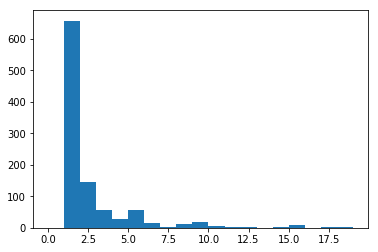

In [15]:
tautomers = [ tautomer.TautomerEnumerator().enumerate( m )  for m in training_set.molecule ]
num_tautomers = [ len(lst) for lst in tautomers ]
print( max(num_tautomers) )
plt.hist (num_tautomers, bins=range(0,20))
plt.show()

## Exercise
Examine some sets of tautomers. Are all the calculated tautomers energetically plausible? Here's an example.

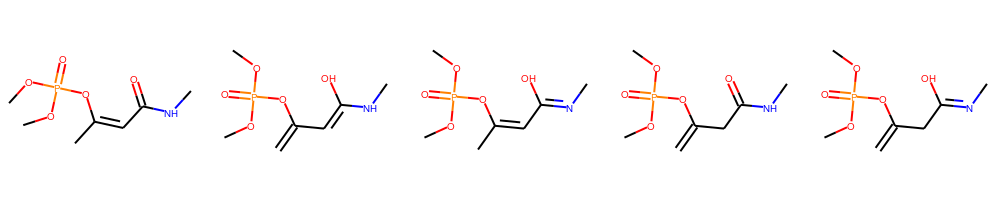

In [20]:
i5 = ( tautomers[i]  for i in range(0, len(tautomers)) if num_tautomers[i]==5 )
next (i5) # skip two less interesting ones
next (i5) 
ms = next (i5) 
Draw.MolsToGridImage( ms, molsPerRow=5 )


## How much can tautomeric state change the fingerprint?
First, we will look at a molecule with many tautomers.

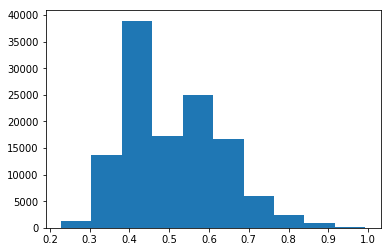

In [38]:
from rdkit import DataStructs
mx = [tautomers[i]  for i in range(0, len(tautomers)) if num_tautomers[i]==max(num_tautomers) ][0]

fps = list( map(Chem.rdmolops.RDKFingerprint, mx) )
sims = []
for i in range(0, len(fps)-1):
    for j in range(i+1, len(fps)):
        sims.append( DataStructs.FingerprintSimilarity(fps[i], fps[j]) )
plt.hist (sims)
plt.show()

Next, look at all molecules with tautomers and compare the tautomer from the original dataset with a randomly chosen one.

0.39786760336871474


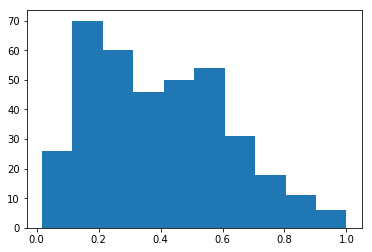

In [54]:
import random
#many = [tautomers[i]  for i in range(0, len(tautomers)) if num_tautomers[i]>1 ]

sims = []
for ms in tautomers:
    if len(ms)<2:
        continue
    other = ms[random.randint(1, len(ms)-1)]
    sim = DataStructs.FingerprintSimilarity(Chem.rdmolops.RDKFingerprint(ms[0]), Chem.rdmolops.RDKFingerprint(other))
    sims.append( sim )
print(numpy.average(sims))
plt.hist (sims)
plt.show()

In [67]:
FINGERPRINTS = [  
        Chem.rdmolops.PatternFingerprint, # NOTE: This function is experimental. The API or results may change from release to release.
        Chem.rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect,
        Chem.rdMolDescriptors.GetMACCSKeysFingerprint,
    
        # these have options for path length, but we stick with the defaults
        Chem.rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect,
        Chem.rdmolops.LayeredFingerprint,   
    
        # these are handled later because they have options relevant to tautomer sensitivity
        #rdmolops.RDKFingerprint,    
        # Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect  
]


def get_tautomer_similarity(fp):
    sims = []
    for ms in tautomers:
        if len(ms)<2:
            continue
        other = ms[random.randint(1, len(ms)-1)]
        sim = DataStructs.FingerprintSimilarity(fp(ms[0]), fp(other))
        sims.append( sim )
    return numpy.average(sims)

for fp in FINGERPRINTS:
    print(get_tautomer_similarity(fp), fp.__name__)
    

fp = lambda m: Chem.rdmolops.RDKFingerprint(m, useHs=False, useBondOrder=False)
print(get_tautomer_similarity(fp), 'RDKFingerprint useHs=False, useBondOrder=False')

fp = lambda m: Chem.rdmolops.RDKFingerprint(m, useHs=True, useBondOrder=True)
print(get_tautomer_similarity(fp), 'RDKFingerprint useHs=True, useBondOrder=True')
        
fp = lambda m: Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius, useBondTypes=False)
print(get_tautomer_similarity(fp), 'GetMorganFingerprintAsBitVect useBondTypes=False') 
fp = lambda m: Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius, useBondTypes=True)
print(get_tautomer_similarity(fp), 'GetMorganFingerprintAsBitVect useBondTypes=True') 


0.8125489819276093 PatternFingerprint
0.467105279704372 GetHashedTopologicalTorsionFingerprintAsBitVect
0.7932005631125013 GetMACCSKeysFingerprint
0.58052385997126 GetHashedAtomPairFingerprintAsBitVect
0.8766889512598129 LayeredFingerprint
0.9095912338480564 RDKFingerprint useHs=False, useBondOrder=False
0.40855782983548045 RDKFingerprint useHs=True, useBondOrder=True
0.32460267249976205 GetMorganFingerprintAsBitVect useBondTypes=False
0.3236835573896592 GetMorganFingerprintAsBitVect useBondTypes=True


## Expand the training set with tautomers

Whichever tautomer is present in the solid state, once in solution a molecule will adopt the energetically optimal tautomeric form, or to be more exact an equilibrium distribution. So different tautomers don't have different solubilities. Rather, solubility is a property of the compound, which takes a range of tautomeric forms. 

There are three ways to deal with this.
- use a tautomer-insensitive fingerprint
- represent each molecule with its canonical tautomer
- expand the training set by adding all tautomers

Let's amplify our training data, by adding a row for each possible tautomer.

In [36]:

training_molecules = []
training_y = []
for m,y in zip(training_set['molecule'], training_set['y']):
    for t in tautomer.TautomerEnumerator().enumerate( m ):
        training_molecules.append(t)
        training_y.append(y)
len(training_molecules)

3601

That's more than three times as much training data. Does it improve our model?

## Support Vector Regression 

In [ ]:
from sklearn import utils

def gram_matrix(X, Y=None):
    if Y:
        pass
    else:
        Y = X
    gm = numpy.zeros([len(X), len(Y)], dtype=numpy.float64) 
    for i in range(0, len(X)):
        for j in range(0, len(Y)):
            gm[i, j] =  DataStructs.FingerprintSimilarity(X[i],Y[j], 
                metric=DataStructs.cDataStructs.TanimotoSimilarity)
    return numpy.array(gm, dtype=numpy.float64)



fingerprint = lambda m: Chem.rdmolops.RDKFingerprint(m, maxPath=3)
training_fp = list( map(fingerprint, training_molecules) )
#kernel = Kernel.MoleculeKernel(fingerprint=fingerprint)  

# see http://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVR.html
model = svm.NuSVR(kernel='precomputed', 
                # degree=3, gamma='auto', coef0=0.0, # all irrelevant with precomputed kernel
                tol=1e-2, # tolerance for stopping, should match experimental error
                # C=1, # lower values imply more regularization
                nu=0.1, # default is 0.5
) 

# Can be slow. Time is square of size of training set.
training_gm = gram_matrix( training_fp )  

model.fit(
        training_gm, # precomputed
        training_y,  # dependent values, to be predicted
)

test_fp = test_set['molecule'].apply(fingerprint)
test_gm = gram_matrix(list(test_fp),  training_fp )
predicted = model.predict( test_gm )
residuals = test_set['y'] - predicted
# rmse = math.sqrt(mean_squared_error(y, predicted))
rsquare = r2_score(test_set['y'],predicted)

# pickle the gram matrices for future use
#with open( "../model_data/solubility_gm.p", "wb" ) as f:
#    pickle.dump( (training_fp, training_gm, training_set['y'], test_fp, test_gm, test_set['y'], training_set['molecule'], test_set['molecule']), f )
                
# display results
plt.figure()
#plt.xlabel('Residual delHSub. RSquared: %(rsq)g %(kernel)s' %{"rsq":rsquare, "kernel":kernel.__repr__()})
plt.ylabel('Frequency')
plt.hist(residuals, bins=numpy.linspace(-10, 10, 40), normed=1)
plt.show()
print('Number of support vectors: {}  R Squared: {}'.format( len(model.support_), rsquare ))

With these same parameters and the original training set, our [Support Vector Regression](../SVR.ipynb) had an $R^2$ of only 0.52.

## Exercise
Do a grid search for optimal $C$ and $vu$. Is the performance with the extended training set still improved?

## Exercise
For molecules in the test set which have tautomers, how much does the prediction vary by tautomer?

[Next](Visualization.ipynb)
[Up](Welcome.ipynb) [Support Vector Classification](SVC.ipynb) [Previous](SVM.ipynb)

Copyright STFC 2018